# Reproducing Røth & Tarantola

### Intro to PyTorch for regression tasks

We'll use Pytorch together with supporting libraries `tensorlayers` and `skorch` to train a regressor that will map synthetic accoustic seismic waveforms and their corresponding velocity profiles. The dataset was put together by Lukas Mosser and is hosted on github here: [https://github.com/LukasMosser/SNIST](https://github.com/LukasMosser/SNIST)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
urls = [
    'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/train/train_amplitudes.npy',
    'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/train/train_velocities.npy',
    'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes.npy',
    'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_velocities.npy',
    'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes_noise_1.npy',
    'https://raw.githubusercontent.com/LukasMosser/SNIST/master/data/test/test_amplitudes_noise_2.npy',
]

## ETL and EDA

Numpy allows you to point at URL data sources. It'll take care of downloading them and keeping reference of where they are with respect to a root folder specified by the user.

In [3]:
ds = np.DataSource('../data/')

X = np.load(ds.open(urls[0], mode='rb'))
y = np.load(ds.open(urls[1], mode='rb'))

In [4]:
X.shape, y.shape

((600, 271, 20), (600, 9))

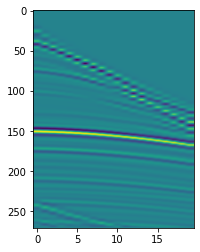

In [5]:
plt.imshow(X[0], aspect=0.1)

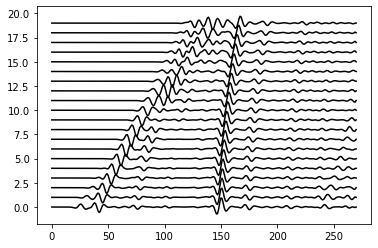

In [6]:
for i, trace in enumerate(X[0].T):
    plt.plot(30 * trace + i, 'k')

In [7]:
y[0]

array([1614.6808, 2120.0837, 2221.0603, 2760.1326, 2866.8733, 3133.5537,
       3138.5488, 3551.7163, 4000.    ], dtype=float32)

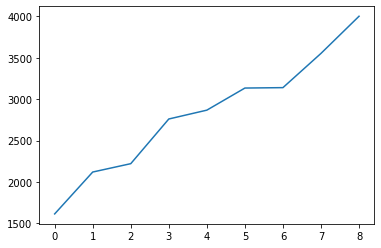

In [8]:
plt.plot(y[0])

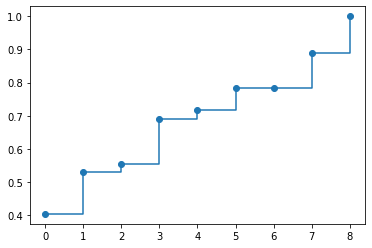

In [32]:
plt.step(range(len(y[0])), y[0], 'o-', where='post')

# NB Missing step at end (compared to paper).

(8.0, 0.0)

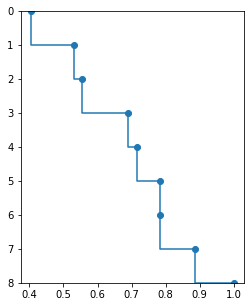

In [31]:
fig,ax = plt.subplots(figsize=(4, 5))
ax.step(y[0], range(len(y[0])), 'o-', where='pre')  # <-- Note 'pre' for vertical.
ax.set_ylim(8, 0)

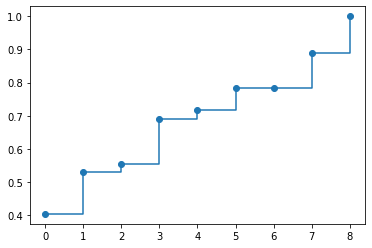

In [21]:
plt.step(range(len(y[0])), y[0], 'o-', where='post')

We can try to reproduce one of the figures in the paper:

(0.35, 1.0)

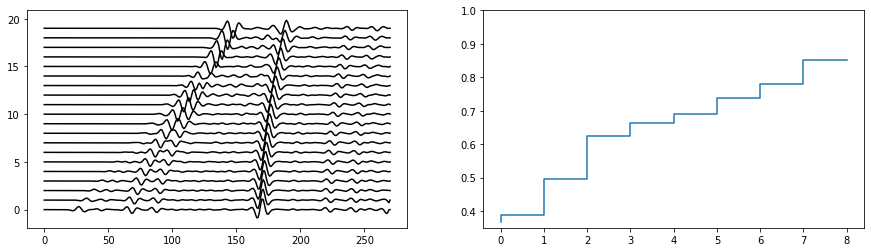

In [10]:
example = 19

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 4))
for i, trace in enumerate(X[example].T):
    ax0.plot(30 * trace + i, 'k')
ax1.step(range(9), y[example]/y.max())
ax1.set_ylim(0.35, 1)

Let's define some dataset parameters.

In [11]:
N, N_samples, N_recorders = X.shape
N_val = 150  # Validation samples.
N_train = N - N_val

## Make training and validation datasets

Makes train and val:

In [12]:
X_train, y_train = X[:N_train], y[:N_train]
X_val, y_val = X[N_train:], y[N_train:]

Reshape:

In [13]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

Standardize the inputs — we can't use `sklearn.preprocessing.StandardScaler` because it scales each feature (sample position, in our case) independently.

In [14]:
train_mean, train_std = X_train.mean(), X_train.std()

X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std  # <-- use train's stats for val.

We must normalize the target too.

In [15]:
vmax = y_train.max()

y_train /= vmax
y_val /= vmax

## Implement in `sklearn`

### EXERCISE



## Implement in `torch`

Now we can try using a deep learning framework.

In [27]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [28]:
import torch.utils.data as utils

X_train_ = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_ = torch.tensor(y_train, dtype=torch.float).to(device)

train_data = utils.TensorDataset(X_train_, y_train_)
train_loader = utils.DataLoader(train_data, batch_size=X_train.shape[0], shuffle=True)

X_val_ = torch.tensor(X_val, dtype=torch.float).to(device)
y_val_ = torch.tensor(y_val, dtype=torch.float).to(device)

val_data = utils.TensorDataset(X_val_, y_val_)
val_loader = utils.DataLoader(val_data, batch_size=X_val.shape[0], shuffle=False)

There are two main ways to construct networks in PyTorch: the 'sequential' way and the object oriented way. (Then there's `skorch`.)

In [29]:
from torch import nn

N_hidden = 25  # Units in hidden layer.
N_target = y_train.shape[1]

# Setup a sequential network based on Roeth and Tarantola 1994.
model = nn.Sequential(
            nn.Linear(N_recorders*N_samples, N_hidden),
            nn.Sigmoid(),
            nn.Linear(N_hidden, N_target),
            nn.Sigmoid(),
        )

def init_weights(m):
    """Xavier normal initializer."""
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.00)
    return

model.apply(init_weights)
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=5420, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=9, bias=True)
  (3): Sigmoid()
)


In [49]:
from torch import nn

class Net(torch.nn.Module):
    def __init__(self, inputs, hidden, target):
        super().__init__()
        self.hidden = nn.Linear(inputs, hidden)
        self.output = nn.Linear(hidden, target)

        # Optional.
        nn.init.xavier_normal_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        z1 = self.hidden(x)
        a1 = torch.sigmoid(z1)
        z2 = self.output(a1)
        a2 = torch.sigmoid(z2)
        return a2
    
N_hidden = 25  # Units in hidden layer.
N_target = y_train.shape[1]

model = Net(N_recorders*N_samples, N_hidden, N_target).to(device)
print(model)

Net(
  (hidden): Linear(in_features=5420, out_features=25, bias=True)
  (output): Linear(in_features=25, out_features=9, bias=True)
)


Now some neural network parameters:

In [50]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0, weight_decay=0)
stepper = optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-5)
criterion = nn.MSELoss(reduction='sum')

In [51]:
lowest_loss = np.inf
losses = {'train': [], 'val': []}

epochs = 250

for epoch in range(1, epochs+1):

    model.train()
    train_loss = 0.0

    for xi, yi in train_loader:
        optimizer.zero_grad()
        y_hat = model(xi)
        loss = criterion(y_hat, yi)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
                
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xi, yi in val_loader:
            y_hat = model(xi)
            loss = criterion(y_hat, yi)
            val_loss += loss.item()
            
    stepper.step(val_loss)

    # Scale the loss.
    train_loss = np.sqrt(train_loss / (9 *len(train_loader.dataset))) * vmax
    val_loss = np.sqrt(val_loss / (9 * len(val_loader.dataset))) * vmax

    # Capture the model if it's the best.
    if lowest_loss > val_loss:
        torch.save(model.state_dict(), "./model.pth")
        lowest_loss = val_loss

    # Capture the losses for plotting.
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']

    # Print info every so often.
    if epoch % 10 == 0:
        print(f"{epoch}  ", end='')
        print(f"Train {train_loss:.1f} m/s,  ", end='')
        print(f"Val {val_loss:.1f} m/s,  ", end='')
        print(f"lr {lr:.5f}")
        

10  Train 518.2 m/s,  Val 575.4 m/s,  lr 0.01000
20  Train 315.8 m/s,  Val 426.2 m/s,  lr 0.01000
30  Train 242.8 m/s,  Val 388.5 m/s,  lr 0.01000
40  Train 226.8 m/s,  Val 396.0 m/s,  lr 0.01000
50  Train 191.2 m/s,  Val 370.8 m/s,  lr 0.01000
60  Train 190.4 m/s,  Val 366.0 m/s,  lr 0.00100
70  Train 157.7 m/s,  Val 353.7 m/s,  lr 0.00100
80  Train 156.0 m/s,  Val 353.0 m/s,  lr 0.00100
90  Train 154.9 m/s,  Val 352.7 m/s,  lr 0.00100
100  Train 153.8 m/s,  Val 352.4 m/s,  lr 0.00100
110  Train 152.9 m/s,  Val 352.1 m/s,  lr 0.00100
120  Train 151.9 m/s,  Val 351.9 m/s,  lr 0.00100
130  Train 151.1 m/s,  Val 351.7 m/s,  lr 0.00100
140  Train 150.2 m/s,  Val 351.5 m/s,  lr 0.00100
150  Train 149.4 m/s,  Val 351.3 m/s,  lr 0.00100
160  Train 148.7 m/s,  Val 351.1 m/s,  lr 0.00100
170  Train 147.9 m/s,  Val 350.9 m/s,  lr 0.00100
180  Train 147.2 m/s,  Val 350.7 m/s,  lr 0.00100
190  Train 146.5 m/s,  Val 350.5 m/s,  lr 0.00100
200  Train 145.8 m/s,  Val 350.4 m/s,  lr 0.00100
210  Trai

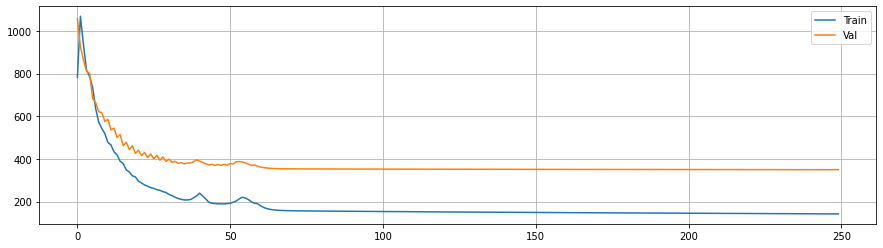

In [52]:
plt.figure(figsize=(15, 4))
plt.plot(losses['train'], label='Train')
plt.plot(losses['val'], label='Val')
plt.grid()
plt.legend()

## Test the model

We can make predictions with the trained model:

In [53]:
X_test = np.load(ds.open(urls[2], mode='rb'))
y_test = np.load(ds.open(urls[3], mode='rb'))

Reshape and scale:

In [1]:
def predict_and_score(X, y, Xmean, Xstd, ymax, model, criterion, device):
    """
    Take some data, scale it, predict, and return y_pred and rmse.
    """
    X = X.reshape(X.shape[0], -1)
    X = (X - Xmean) / Xstd
    X_ = torch.tensor(X, dtype=torch.float).to(device)
    y_ = torch.tensor(y, dtype=torch.float).to(device)

    data = utils.TensorDataset(X_, y_)
    loader = utils.DataLoader(data, shuffle=False, batch_size=X.shape[0])
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_) * ymax
        loss = criterion(y_pred, y_) / y.size
        rmse = np.sqrt(loss)

    return y_pred, rmse

In [2]:
params = {
    'Xmean': train_mean,
    'Xstd': train_std,
    'ymax': vmax,
    'model': model,
    'criterion': criterion,
    'device': device,
}

NameError: name 'train_mean' is not defined

In [55]:
y_pred, rmse = predict_and_score(X_test, y_test, **params)

rmse

tensor(346.2595)

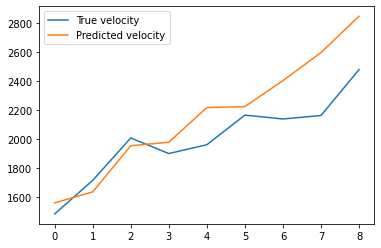

In [56]:
example = 6

plt.plot(y_test[example], label='True velocity')
plt.plot(y_pred[example], label='Predicted velocity')
plt.legend()

## Reproduce one of the original figures

We'll need the proper data samples:

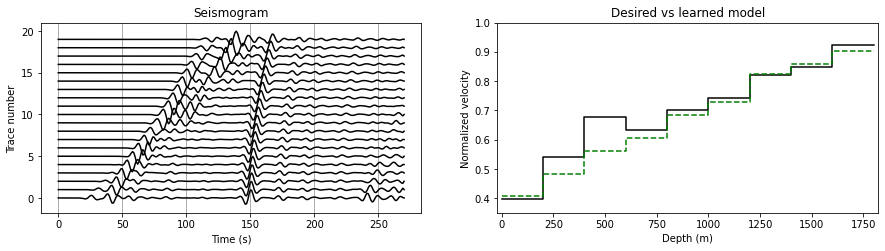

In [58]:
example = 19

y_test_data = np.pad(y_test[example]/vmax, (0, 1), mode='edge')
y_pred_data = np.pad(y_pred[example]/vmax, (0, 1), mode='edge')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 3.5))
for i, trace in enumerate(X_test[example].reshape(N_samples, N_recorders).T):
    ax0.plot(30 * trace + i, 'k')
ax0.grid(c='k', alpha=0.4, axis='x')
ax0.set_title("Seismogram")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Trace number")
ax1.step(np.arange(0, 2000, 200), y_test_data, 'k', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data, 'g--', where='post')
ax1.set_title("Desired vs learned model")
ax1.set_ylim(0.35, 1)
ax1.set_xlim(-20, 1820)
ax1.set_xlabel('Depth (m)')
ax1.set_ylabel('Normalized velocity')
plt.show()

## Noisy data

In [59]:
X_test_noisy = np.load(ds.open(urls[4], mode='rb'))

y_pred_noisy, rmse = predict_and_score(X_test_noisy, y_test, **params)

rmse

tensor(396.7133)

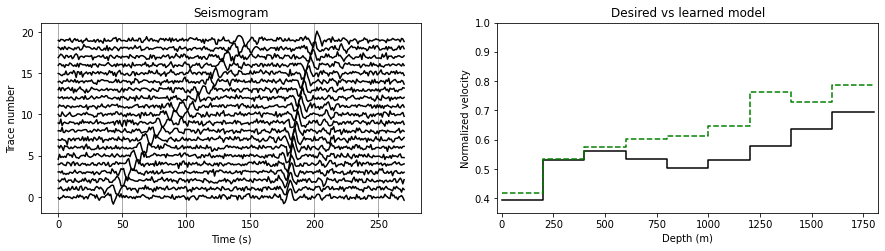

In [60]:
example = 20

y_test_data = np.pad(y_test[example]/vmax, (0, 1), mode='edge')
y_pred_data = np.pad(y_pred[example]/vmax, (0, 1), mode='edge')
y_pred_data_n1 = np.pad(y_pred_noisy[example]/vmax, (0, 1), mode='edge')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 3.5))
for i, trace in enumerate(X_test_noisy[example].reshape(N_samples, N_recorders).T):
    ax0.plot(30 * trace + i, 'k')
ax0.grid(c='k', alpha=0.4, axis='x')
ax0.set_title("Seismogram")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Trace number")
ax1.step(np.arange(0, 2000, 200), y_test_data, 'k', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data, 'g--', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data_n1, c='cyan', ls='--', where='post')
ax1.set_title("Desired vs learned model")
ax1.set_ylim(0.35, 1)
ax1.set_xlim(-20, 1820)
ax1.set_xlabel('Depth (m)')
ax1.set_ylabel('Normalized velocity')
plt.show()

In [61]:
X_test_noisier = np.load(ds.open(urls[5], mode='rb'))

y_pred_noisier, rmse = predict_and_score(X_test_noisier, y_test, **params)

rmse

tensor(465.5155)

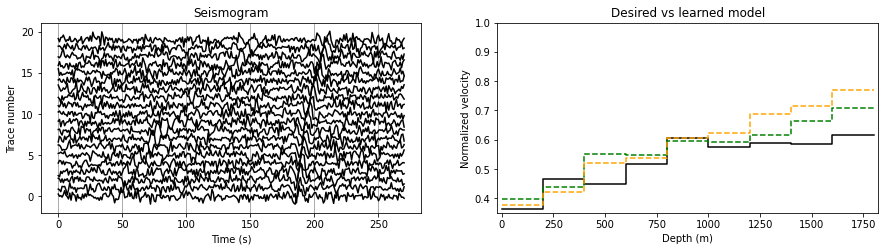

In [62]:
example = 99

y_test_data = np.pad(y_test[example]/vmax, (0, 1), mode='edge')
y_pred_data = np.pad(y_pred[example]/vmax, (0, 1), mode='edge')
y_pred_data_n1 = np.pad(y_pred_noisy[example]/vmax, (0, 1), mode='edge')
y_pred_data_n2 = np.pad(y_pred_noisier[example]/vmax, (0, 1), mode='edge')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 3.5))
for i, trace in enumerate(X_test_noisier[example].reshape(N_samples, N_recorders).T):
    ax0.plot(30 * trace + i, 'k')
ax0.grid(c='k', alpha=0.4, axis='x')
ax0.set_title("Seismogram")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Trace number")
ax1.step(np.arange(0, 2000, 200), y_test_data, 'k', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data, 'g--', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data_n1, c='cyan', ls='--', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data_n2, c='orange', ls='--', where='post')
ax1.set_title("Desired vs learned model")
ax1.set_ylim(0.35, 1)
ax1.set_xlim(-20, 1820)
ax1.set_xlabel('Depth (m)')
ax1.set_ylabel('Normalized velocity')
plt.show()

## Simplifying things with `skorch`

We still need to construct the model:

In [63]:
model = Net(N_recorders*N_samples, N_hidden, N_target).to(device)

The rest of the workflow, in particular the training loop, is much easier:

In [64]:
from skorch import NeuralNetRegressor

model = NeuralNetRegressor(
    model,
    max_epochs=200,
    lr=0.01,
    # Default loss is MSE.
)

model.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0547        0.0506  0.0287
      2        0.0544        0.0504  0.0310
      3        0.0541        0.0502  0.0318
      4        0.0539        0.0500  0.0364
      5        0.0536        0.0498  0.0351
      6        0.0534        0.0496  0.0390
      7        0.0531        0.0494  0.0360
      8        0.0529        0.0492  0.0321
      9        0.0526        0.0490  0.0365
     10        0.0524        0.0488  0.0325
     11        0.0521        0.0486  0.0350
     12        0.0519        0.0483  0.0338
     13        0.0516        0.0481  0.0354
     14        0.0514        0.0479  0.0366
     15        0.0512        0.0477  0.0363
     16        0.0509        0.0475  0.0354
     17        0.0507        0.0474  0.0338
     18        0.0504        0.0472  0.0370
     19        0.0502        0.0470  0.0354
     20        0.0500        0.0468  0.0347
     21        0.0497        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (hidden): Linear(in_features=5420, out_features=25, bias=True)
    (output): Linear(in_features=25, out_features=9, bias=True)
  ),
)

In [65]:
y_pred = model.predict(X_val) * vmax
y_pred[0]

array([1590.3074, 1556.8424, 2345.9592, 2314.959 , 1748.783 , 2361.708 ,
       1845.8956, 2248.2122, 2372.556 ], dtype=float32)

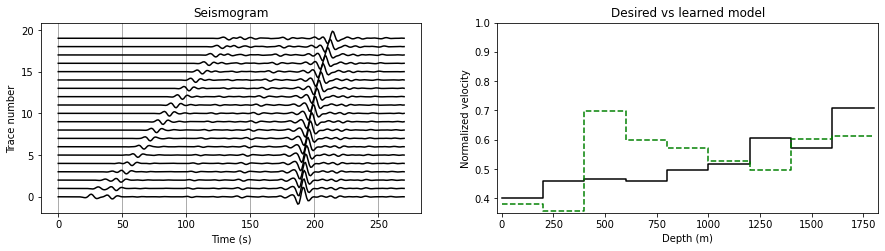

In [67]:
example = 1

y_test_data = np.pad(y_test[example]/vmax, (0, 1), mode='edge')
y_pred_data = np.pad(y_pred[example]/vmax, (0, 1), mode='edge')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 3.5))
for i, trace in enumerate(X_test[example].reshape(N_samples, N_recorders).T):
    ax0.plot(30 * trace + i, 'k')
ax0.grid(c='k', alpha=0.4, axis='x')
ax0.set_title("Seismogram")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Trace number")
ax1.step(np.arange(0, 2000, 200), y_test_data, 'k', where='post')
ax1.step(np.arange(0, 2000, 200), y_pred_data, 'g--', where='post')
ax1.set_title("Desired vs learned model")
ax1.set_ylim(0.35, 1)
ax1.set_xlim(-20, 1820)
ax1.set_xlabel('Depth (m)')
ax1.set_ylabel('Normalized velocity')
plt.show()